# Experiment C: 2-Class Engagement Rate Classification
## LinkedIn Engagement Prediction — TrendPilot

**Experiment:** Binary classification — Below Average vs Above Average.
**Question:** Does removing the ambiguous middle class improve model confidence and F1?

---

## Motivation

Across NB11, NB11a, and NB11b, the Average class (Class 1) was consistently
the worst-performing class:

| Experiment | Average Class F1 |
|------------|------------------|
| NB11       | 0.46             |
| NB11a      | 0.45             |
| NB11b      | 0.24             |

Average content is structurally ambiguous. It lies on both decision boundaries
and is genuinely difficult to separate from Below or Above using rule-based
content features. It may simply reflect noise rather than a learnable signal.

This experiment collapses to a binary problem:

- **Class 0 - Below Average:** engagement_rate < median
- **Class 1 - Above Average:** engagement_rate >= median

Removing the middle class forces the model to commit to a direction.
The random baseline rises from 0.333 to **0.500**.

## What to look for
- Does lift over random baseline improve vs 3-class models?
- Is the model more confident (higher precision/recall balance)?
- Which features best separate high from low engagement?
- Does tier balance improve further?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, accuracy_score, ConfusionMatrixDisplay
)
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
print('Libraries loaded.')

Libraries loaded.


## 1. Load Data

In [2]:
data = pd.read_csv('../data/selected_features_data.csv')
print(f'Shape: {data.shape}')
print(f'Columns ({len(data.columns)}): {list(data.columns)}')

Shape: (772, 94)
Columns (94): ['name', 'content', 'reactions', 'comments', 'time_spent', 'location', 'followers', 'influencer_avg_comments', 'reactions_per_sentiment', 'influencer_avg_engagement', 'comments_vs_influencer_avg', 'reactions_vs_influencer_avg', 'influencer_total_engagement', 'reactions_per_word', 'comments_per_word', 'sentiment_compound', 'text_difficult_words_count', 'total_engagement_elements', 'readability_flesch_kincaid', 'comment_to_reaction_ratio', 'base_score_capped', 'text_lexical_diversity', 'influencer_avg_sentiment', 'influencer_std_comments', 'readability_gunning_fog', 'sentence_count', 'text_avg_sentence_length', 'topic_count', 'influencer_std_reactions', 'sentiment_x_readability', 'ner_location_count', 'style_question_marks', 'ner_org_count', 'style_has_parentheses', 'influencer_avg_base_score', 'ner_person_count', 'ner_date_count', 'influencer_consistency_reactions', 'unique_emoji_count', 'hashtag_count_extracted', 'style_quote_marks', 'has_aspirational', '

## 2. Build Engagement Rate Target

```
engagement_rate = (reactions + comments) / (followers / 1000)
```

The median is used as the single class boundary.
Posts above the median are Above Average; posts below are Below Average.
The ambiguous middle ground is deliberately eliminated.


In [3]:
df = data.copy()
df['followers'] = df['followers'].clip(lower=1)
df['engagement_rate'] = (df['reactions'] + df['comments']) / (df['followers'] / 1000)

print('Engagement rate summary:')
print(df['engagement_rate'].describe().round(3))
print(f'Median: {df["engagement_rate"].median():.2f} engagements per 1k followers')
print('This is the single class boundary for the 2-class model')


Engagement rate summary:
count     772.000
mean       31.310
std        86.321
min         0.010
25%         1.177
50%         5.879
75%        25.499
max      1132.075
Name: engagement_rate, dtype: float64
Median: 5.88 engagements per 1k followers
This is the single class boundary for the 2-class model


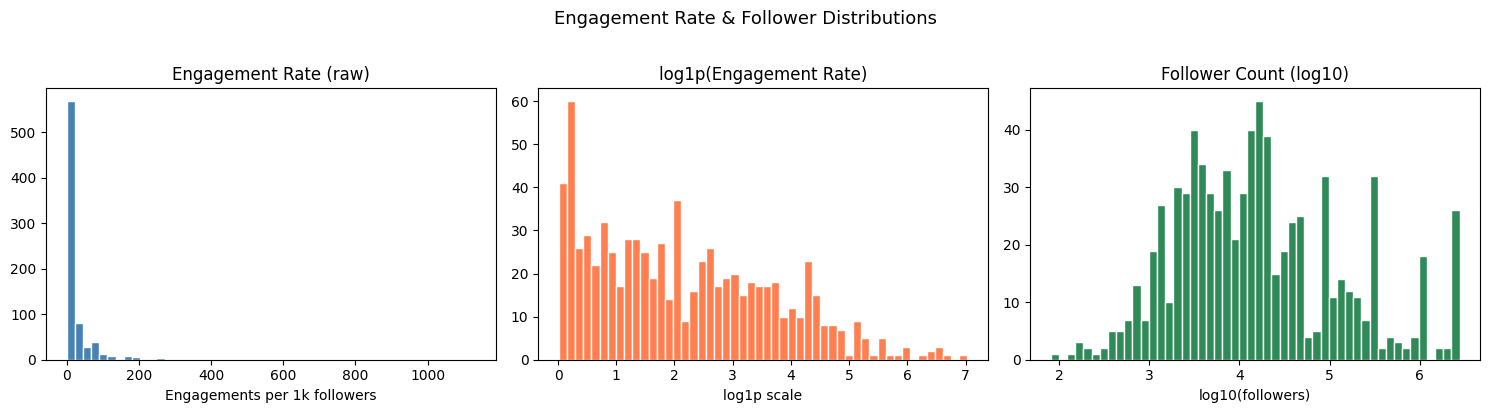

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Raw distribution
axes[0].hist(df['engagement_rate'], bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('Engagement Rate (raw)')
axes[0].set_xlabel('Engagements per 1k followers')

# Log distribution
axes[1].hist(np.log1p(df['engagement_rate']), bins=50, color='coral', edgecolor='white')
axes[1].set_title('log1p(Engagement Rate)')
axes[1].set_xlabel('log1p scale')

# Follower distribution
axes[2].hist(np.log10(df['followers']+1), bins=50, color='seagreen', edgecolor='white')
axes[2].set_title('Follower Count (log10)')
axes[2].set_xlabel('log10(followers)')

plt.suptitle('Engagement Rate & Follower Distributions', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig('../data/11_distributions.png', dpi=100, bbox_inches='tight')
plt.show()

## 3. Train / Test Split FIRST

Split before assigning class labels so that percentile thresholds
are computed from training data only — preventing any leakage from
test distribution into the class boundaries.

In [5]:
# Stratify on binary split for balanced train/test classes
df['_tmp_class'] = (df['engagement_rate'] >= df['engagement_rate'].median()).astype(int)

df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=RANDOM_STATE,
    stratify=df['_tmp_class']
)
df_train = df_train.copy().reset_index(drop=True)
df_test  = df_test.copy().reset_index(drop=True)
df_train.drop(columns=['_tmp_class'], inplace=True)
df_test.drop(columns=['_tmp_class'], inplace=True)

print(f'Train: {len(df_train)} posts | Test: {len(df_test)} posts')
print(f'Train authors: {df_train["name"].nunique()}')


Train: 617 posts | Test: 155 posts
Train authors: 408


## 4. Assign 2-Class Labels (Training Median)

Single threshold: the median engagement rate of the training set.

- Class 0: rate < median (Below Average)
- Class 1: rate >= median (Above Average)

Threshold derived from training data only.


In [6]:
median_rate = df_train['engagement_rate'].quantile(0.5)

print('Training-derived threshold:')
print(f'  median = {median_rate:.3f}  (engagements per 1k followers)')
print(f'  Class 0: rate < {median_rate:.2f}  (Below Average)')
print(f'  Class 1: rate >= {median_rate:.2f}  (Above Average)')

LABEL_NAMES = {0: f'Below (<{median_rate:.1f})', 1: f'Above (>={median_rate:.1f})'}

df_train['engagement_class'] = (df_train['engagement_rate'] >= median_rate).astype(int)
df_test['engagement_class']  = (df_test['engagement_rate']  >= median_rate).astype(int)

print(f'\nClass distribution - TRAINING:')
for c in [0, 1]:
    n = (df_train['engagement_class'] == c).sum()
    print(f'  Class {c} {LABEL_NAMES[c]:30s}: {n:4d} ({n/len(df_train)*100:.1f}%)')

print(f'\nClass distribution - TEST:')
for c in [0, 1]:
    n = (df_test['engagement_class'] == c).sum()
    print(f'  Class {c} {LABEL_NAMES[c]:30s}: {n:4d} ({n/len(df_test)*100:.1f}%)')

print(f'\nRandom baseline for 2-class: ~0.500 (vs 0.333 for 3-class)')


Training-derived threshold:
  median = 5.985  (engagements per 1k followers)
  Class 0: rate < 5.98  (Below Average)
  Class 1: rate >= 5.98  (Above Average)

Class distribution - TRAINING:
  Class 0 Below (<6.0)                  :  308 (49.9%)
  Class 1 Above (>=6.0)                 :  309 (50.1%)

Class distribution - TEST:
  Class 0 Below (<6.0)                  :   78 (50.3%)
  Class 1 Above (>=6.0)                 :   77 (49.7%)

Random baseline for 2-class: ~0.500 (vs 0.333 for 3-class)


## 5. Follower Tier Features

Raw `followers` is dropped (it's in the target denominator).  
We replace it with two transformed proxies that carry creator-context
information without leaking the exact normalisation value.

| Tier | Range | Rationale |
|------|-------|----------|
| micro | < 10k | Personal/niche audiences |
| small | 10k–50k | Growing creators |
| medium | 50k–200k | Established voices |
| large | > 200k | Macro influencers |

In [7]:
def add_follower_features(df_):
    df_ = df_.copy()
    df_['log_followers'] = np.log1p(df_['followers'])
    df_['follower_tier'] = pd.cut(
        df_['followers'],
        bins=[0, 10_000, 50_000, 200_000, np.inf],
        labels=[0, 1, 2, 3],   # micro, small, medium, large
        include_lowest=True
    ).astype(int)
    return df_

df_train = add_follower_features(df_train)
df_test  = add_follower_features(df_test)

print('Follower tier distribution (full dataset):')
tier_labels = {0: 'micro (<10k)', 1: 'small (10k-50k)', 2: 'medium (50k-200k)', 3: 'large (>200k)'}
tier_counts = pd.concat([df_train, df_test])['follower_tier'].value_counts().sort_index()
for t, n in tier_counts.items():
    print(f'  {tier_labels[t]:22s}: {n:4d} ({n/772*100:.1f}%)')

Follower tier distribution (full dataset):
  micro (<10k)          :  345 (44.7%)
  small (10k-50k)       :  225 (29.1%)
  medium (50k-200k)     :   92 (11.9%)
  large (>200k)         :  110 (14.2%)


## 6. Feature Set — Drop Leaky Columns

In [8]:
# ── Columns to DROP (leakage or direct engagement signals) ──────────────────
DROP_COLS = [
    # Raw targets / used in target construction
    'reactions', 'comments', 'followers', 'engagement_rate', 'engagement_class',
    # Derived directly from reactions/comments (same-post leakage)
    'base_score_capped',
    'reactions_per_word', 'comments_per_word', 'reactions_per_sentiment',
    'comment_to_reaction_ratio',
    # Influencer-history features (aggregated from same dataset — data leakage)
    'influencer_avg_reactions', 'influencer_std_reactions', 'influencer_median_reactions',
    'influencer_avg_comments', 'influencer_std_comments', 'influencer_median_comments',
    'influencer_avg_base_score', 'influencer_avg_sentiment',
    'influencer_post_count', 'influencer_total_engagement', 'influencer_avg_engagement',
    'influencer_consistency_reactions',
    'reactions_vs_influencer_avg', 'comments_vs_influencer_avg',
    # Metadata / text / identifiers — not ML features
    'name', 'content', 'time_spent', 'location',
]

# Only drop cols that actually exist
drop_existing = [c for c in DROP_COLS if c in df_train.columns]
print(f'Dropping {len(drop_existing)} columns (leakage/metadata):')
for c in drop_existing:
    print(f'  {c}')

# ── Keep all remaining numeric / binary columns as features ─────────────────
all_cols = df_train.columns.tolist()
feature_cols = [c for c in all_cols if c not in drop_existing and c != 'engagement_class']

# Verify all are numeric
non_numeric = [c for c in feature_cols if not pd.api.types.is_numeric_dtype(df_train[c])]
if non_numeric:
    print(f'\nNon-numeric columns removed from features: {non_numeric}')
    feature_cols = [c for c in feature_cols if c not in non_numeric]

print(f'\nTotal features: {len(feature_cols)}')
print('Feature columns:', feature_cols)

Dropping 25 columns (leakage/metadata):
  reactions
  comments
  followers
  engagement_rate
  engagement_class
  base_score_capped
  reactions_per_word
  comments_per_word
  reactions_per_sentiment
  comment_to_reaction_ratio
  influencer_std_reactions
  influencer_avg_comments
  influencer_std_comments
  influencer_avg_base_score
  influencer_avg_sentiment
  influencer_post_count
  influencer_total_engagement
  influencer_avg_engagement
  influencer_consistency_reactions
  reactions_vs_influencer_avg
  comments_vs_influencer_avg
  name
  content
  time_spent
  location

Total features: 73
Feature columns: ['sentiment_compound', 'text_difficult_words_count', 'total_engagement_elements', 'readability_flesch_kincaid', 'text_lexical_diversity', 'readability_gunning_fog', 'sentence_count', 'text_avg_sentence_length', 'topic_count', 'sentiment_x_readability', 'ner_location_count', 'style_question_marks', 'ner_org_count', 'style_has_parentheses', 'ner_person_count', 'ner_date_count', 'uniqu

In [9]:
X_train = df_train[feature_cols].fillna(0)
X_test  = df_test[feature_cols].fillna(0)
y_train = df_train['engagement_class']
y_test  = df_test['engagement_class']

print(f'X_train: {X_train.shape}  |  X_test: {X_test.shape}')
print(f'y_train value counts: {y_train.value_counts().sort_index().to_dict()}')
print(f'y_test  value counts: {y_test.value_counts().sort_index().to_dict()}')

X_train: (617, 73)  |  X_test: (155, 73)
y_train value counts: {0: 308, 1: 309}
y_test  value counts: {0: 78, 1: 77}


## 7. Baseline Models

Binary classification is simpler than 3-class. All three classifiers run
with standard hyperparameters first. The random baseline is 0.500.


In [10]:
def evaluate(model, X_te, y_te, name='Model', verbose=True):
    yp = model.predict(X_te)
    mf1 = f1_score(y_te, yp, average='macro')
    acc = accuracy_score(y_te, yp)
    if verbose:
        print(f'  [{name}]  Macro F1={mf1:.4f}  Acc={acc:.4f}')
        print(classification_report(
            y_te, yp,
            target_names=[LABEL_NAMES[i] for i in [0, 1]],
            zero_division=0
        ))
    return dict(model=name, macro_f1=round(mf1, 4), acc=round(acc, 4))

results = []
sw = compute_sample_weight('balanced', y_train)


In [11]:
print('─' * 60)
print('Random Forest (baseline)')
rf = RandomForestClassifier(
    n_estimators=400, max_depth=10,
    min_samples_split=20, min_samples_leaf=10,
    class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1
)
rf.fit(X_train, y_train)
results.append(evaluate(rf, X_test, y_test, 'RandomForest_base'))

────────────────────────────────────────────────────────────
Random Forest (baseline)
  [RandomForest_base]  Macro F1=0.7871  Acc=0.7871
               precision    recall  f1-score   support

 Below (<6.0)       0.80      0.77      0.78        78
Above (>=6.0)       0.78      0.81      0.79        77

     accuracy                           0.79       155
    macro avg       0.79      0.79      0.79       155
 weighted avg       0.79      0.79      0.79       155



In [12]:
print('─' * 60)
print('XGBoost (baseline)')
xgb_b = xgb.XGBClassifier(
    n_estimators=400, max_depth=5, learning_rate=0.05,
    min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
    eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=-1, verbosity=0
)
xgb_b.fit(X_train, y_train, sample_weight=sw)
results.append(evaluate(xgb_b, X_test, y_test, 'XGBoost_base'))

────────────────────────────────────────────────────────────
XGBoost (baseline)
  [XGBoost_base]  Macro F1=0.8064  Acc=0.8065
               precision    recall  f1-score   support

 Below (<6.0)       0.82      0.79      0.81        78
Above (>=6.0)       0.80      0.82      0.81        77

     accuracy                           0.81       155
    macro avg       0.81      0.81      0.81       155
 weighted avg       0.81      0.81      0.81       155



In [13]:
print('─' * 60)
print('LightGBM (baseline)')
lgb_b = lgb.LGBMClassifier(
    n_estimators=400, max_depth=5, learning_rate=0.05,
    num_leaves=20, min_child_samples=20,
    subsample=0.8, colsample_bytree=0.8,
    class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1, verbose=-1
)
lgb_b.fit(X_train, y_train)
results.append(evaluate(lgb_b, X_test, y_test, 'LightGBM_base'))

────────────────────────────────────────────────────────────
LightGBM (baseline)
  [LightGBM_base]  Macro F1=0.7935  Acc=0.7935
               precision    recall  f1-score   support

 Below (<6.0)       0.79      0.79      0.79        78
Above (>=6.0)       0.79      0.79      0.79        77

     accuracy                           0.79       155
    macro avg       0.79      0.79      0.79       155
 weighted avg       0.79      0.79      0.79       155



## 8. Hyperparameter Tuning — XGBoost + LightGBM

RandomizedSearchCV with stratified 5-fold CV, scored on macro F1.

In [14]:
print('Tuning XGBoost (40 iterations, 5-fold CV)...')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

xgb_grid = {
    'n_estimators':     [200, 400, 600],
    'max_depth':        [3, 4, 5, 6],
    'learning_rate':    [0.01, 0.05, 0.1],
    'min_child_weight': [3, 5, 10],
    'subsample':        [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma':            [0, 0.1, 0.3],
}

xgb_search = RandomizedSearchCV(
    xgb.XGBClassifier(eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=1, verbosity=0),
    xgb_grid, n_iter=40, cv=skf, scoring='f1_macro',
    random_state=RANDOM_STATE, n_jobs=-1, verbose=1
)
xgb_search.fit(X_train, y_train, sample_weight=sw)

print(f'\nXGBoost — Best CV Macro F1: {xgb_search.best_score_:.4f}')
print(f'Best params: {xgb_search.best_params_}')

xgb_tuned = xgb_search.best_estimator_
results.append(evaluate(xgb_tuned, X_test, y_test, 'XGBoost_tuned'))

Tuning XGBoost (40 iterations, 5-fold CV)...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

XGBoost — Best CV Macro F1: 0.7694
Best params: {'subsample': 0.7, 'n_estimators': 400, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
  [XGBoost_tuned]  Macro F1=0.7868  Acc=0.7871
               precision    recall  f1-score   support

 Below (<6.0)       0.82      0.74      0.78        78
Above (>=6.0)       0.76      0.83      0.80        77

     accuracy                           0.79       155
    macro avg       0.79      0.79      0.79       155
 weighted avg       0.79      0.79      0.79       155



In [15]:
print('Tuning LightGBM (30 iterations, 5-fold CV)...')
lgb_grid = {
    'n_estimators':      [200, 400, 600],
    'max_depth':         [3, 4, 5, 6],
    'learning_rate':     [0.01, 0.05, 0.1],
    'num_leaves':        [15, 20, 31, 50],
    'min_child_samples': [10, 20, 30],
    'subsample':         [0.7, 0.8, 0.9],
    'colsample_bytree':  [0.6, 0.8, 1.0],
    'reg_alpha':         [0, 0.1, 0.5],
    'reg_lambda':        [1, 2, 5],
}

lgb_search = RandomizedSearchCV(
    lgb.LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=1, verbose=-1),
    lgb_grid, n_iter=30, cv=skf, scoring='f1_macro',
    random_state=RANDOM_STATE, n_jobs=-1, verbose=1
)
lgb_search.fit(X_train, y_train)

print(f'\nLightGBM — Best CV Macro F1: {lgb_search.best_score_:.4f}')
print(f'Best params: {lgb_search.best_params_}')

lgb_tuned = lgb_search.best_estimator_
results.append(evaluate(lgb_tuned, X_test, y_test, 'LightGBM_tuned'))

Tuning LightGBM (30 iterations, 5-fold CV)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

LightGBM — Best CV Macro F1: 0.7711
Best params: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'num_leaves': 15, 'n_estimators': 400, 'min_child_samples': 30, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
  [LightGBM_tuned]  Macro F1=0.7935  Acc=0.7935
               precision    recall  f1-score   support

 Below (<6.0)       0.80      0.78      0.79        78
Above (>=6.0)       0.78      0.81      0.79        77

     accuracy                           0.79       155
    macro avg       0.79      0.79      0.79       155
 weighted avg       0.79      0.79      0.79       155



## 9. Cross-Validation — Best Model

In [16]:
# Identify best model by macro F1
results_df = pd.DataFrame(results)
best_row = results_df.loc[results_df['macro_f1'].idxmax()]
print(f'Best model so far: {best_row["model"]} — Macro F1 = {best_row["macro_f1"]}')

# Run 5-fold CV for the best model
if 'XGBoost' in best_row['model']:
    best_params = xgb_search.best_params_
    cv_model = xgb.XGBClassifier(**best_params, eval_metric='mlogloss',
                                   random_state=RANDOM_STATE, n_jobs=1, verbosity=0)
    label = 'XGBoost_tuned'
else:
    best_params = lgb_search.best_params_
    cv_model = lgb.LGBMClassifier(**best_params, class_weight='balanced',
                                   random_state=RANDOM_STATE, n_jobs=1, verbose=-1)
    label = 'LightGBM_tuned'

cv_scores = cross_val_score(
    cv_model, X_train, y_train,
    cv=StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1_macro', n_jobs=-1
)
print(f'\n5-Fold CV ({label}):')
print(f'  Per-fold Macro F1: {cv_scores.round(4)}')
print(f'  Mean: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')
print(f'  Random baseline: ~0.333 (3-class random)')

Best model so far: XGBoost_base — Macro F1 = 0.8064

5-Fold CV (XGBoost_tuned):
  Per-fold Macro F1: [0.7016 0.8139 0.7314 0.8455 0.7541]
  Mean: 0.7693 ± 0.0530
  Random baseline: ~0.333 (3-class random)


## 10. Confusion Matrix — Best Model

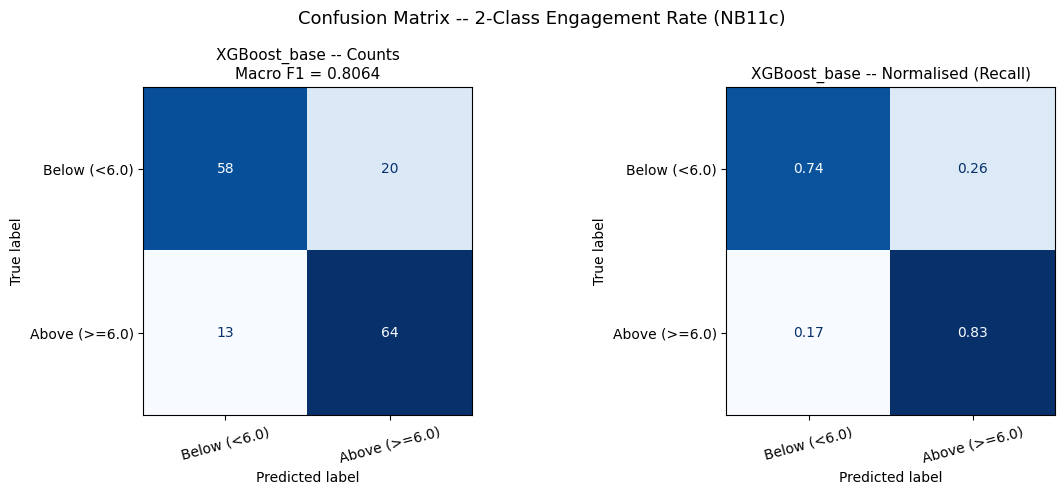

Saved: ../data/11c_confusion_matrix.png


In [17]:
if 'XGBoost' in best_row['model']:
    best_model = xgb_tuned
else:
    best_model = lgb_tuned

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp = ConfusionMatrixDisplay(cm, display_labels=[LABEL_NAMES[i] for i in [0, 1]])
disp.plot(ax=axes[0], colorbar=False, cmap='Blues')
axes[0].set_title(f'{best_row["model"]} -- Counts\nMacro F1 = {best_row["macro_f1"]:.4f}', fontsize=11)
axes[0].tick_params(axis='x', labelrotation=15)

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
disp2 = ConfusionMatrixDisplay(cm_norm.round(2), display_labels=[LABEL_NAMES[i] for i in [0, 1]])
disp2.plot(ax=axes[1], colorbar=False, cmap='Blues')
axes[1].set_title(f'{best_row["model"]} -- Normalised (Recall)', fontsize=11)
axes[1].tick_params(axis='x', labelrotation=15)

plt.suptitle('Confusion Matrix -- 2-Class Engagement Rate (NB11c)', fontsize=13)
plt.tight_layout()
plt.savefig('../data/11c_confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()
print('Saved: ../data/11c_confusion_matrix.png')


## 11. Feature Importance

Top 25 Features:
                   feature  importance
             follower_tier    0.098468
             log_followers    0.067052
           has_org_mention    0.029573
        style_has_question    0.026286
          style_has_quotes    0.023985
   hashtag_count_extracted    0.023915
    text_lexical_diversity    0.023248
             ner_org_count    0.022446
        link_penalty_score    0.021183
   style_exclamation_marks    0.021145
      style_question_marks    0.021117
                 url_count    0.020996
         has_vulnerability    0.020579
     style_has_exclamation    0.019774
            is_multi_topic    0.019368
          topic_leadership    0.019317
        sentiment_compound    0.019155
        style_bullet_count    0.019117
        has_direct_address    0.018757
text_difficult_words_count    0.018635
              topic_career    0.018319
   style_parentheses_count    0.017934
            sentence_count    0.017678
                topic_tech    0.017587
        

<Figure size 1000x900 with 0 Axes>

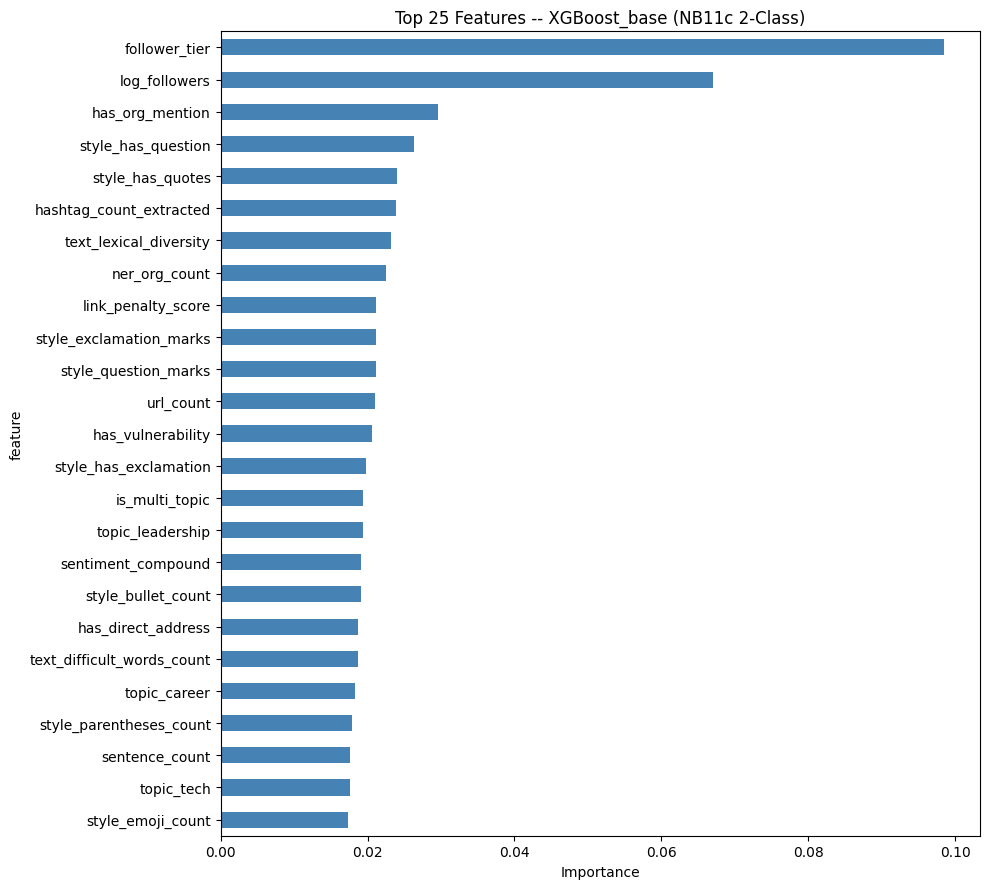

Saved: ../data/11c_feature_importance.png


In [18]:
if hasattr(best_model, 'feature_importances_'):
    imp = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).reset_index(drop=True)

    print('Top 25 Features:')
    print(imp.head(25).to_string(index=False))

    plt.figure(figsize=(10, 9))
    imp.head(25).sort_values('importance').plot(
        x='feature', y='importance', kind='barh',
        figsize=(10, 9), color='steelblue', legend=False
    )
    plt.title(f'Top 25 Features -- {best_row["model"]} (NB11c 2-Class)', fontsize=12)
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig('../data/11c_feature_importance.png', dpi=100, bbox_inches='tight')
    plt.show()
    print('Saved: ../data/11c_feature_importance.png')


## 12. Evaluation by Follower Tier

Key validation: does the model work across all creator sizes?  
A good engagement-rate model should classify content quality fairly
for micro influencers and macro influencers alike.

In [19]:
tier_labels_map = {0: 'micro (<10k)', 1: 'small (10k-50k)',
                   2: 'medium (50k-200k)', 3: 'large (>200k)'}

nb11a_tier_f1 = {0: 0.4091, 1: 0.4587, 2: 0.4444, 3: 0.4222}

tier_results = []
print('=' * 70)
print('Macro F1 by Follower Tier -- NB11c (2-class) vs NB11a (3-class)')
print('=' * 70)
print(f'{"Tier":22s}  {"n":>4}  {"NB11c 2cls":>10}  {"NB11a 3cls":>10}  {"Delta":>7}')
print('-' * 70)

for tier_id, tier_name in tier_labels_map.items():
    mask = df_test['follower_tier'] == tier_id
    n = mask.sum()
    if n == 0 or y_test[mask].nunique() < 2:
        print(f'  {tier_name}: {n} posts -- skipped')
        continue
    yp_t = best_model.predict(X_test[mask])
    mf1  = f1_score(y_test[mask], yp_t, average='macro', zero_division=0)
    ref  = nb11a_tier_f1.get(tier_id, float('nan'))
    delta = mf1 - ref
    d_str = f'+{delta:.4f}' if delta >= 0 else f'{delta:.4f}'
    print(f'  {tier_name:22s}  {n:>4}  {mf1:>10.4f}  {ref:>10.4f}  {d_str:>7}')
    tier_results.append({'tier': tier_name, 'n': n, 'macro_f1': round(mf1,4),
                         'macro_f1_ref': ref, 'delta': round(delta,4)})

print('-' * 70)
overall_delta = best_row['macro_f1'] - 0.5301
d_str2 = f'+{overall_delta:.4f}' if overall_delta >= 0 else f'{overall_delta:.4f}'
print(f'  {"Overall":22s}  {len(y_test):>4}  {best_row["macro_f1"]:>10.4f}  {0.5301:>10.4f}  {d_str2:>7}')
print()
print('Random baseline: 2-class=0.500  |  3-class=0.333')
print('Compare lift: NB11c lift = F1 - 0.500  |  NB11a lift = 0.5301 - 0.333 = +0.197')


Macro F1 by Follower Tier -- NB11c (2-class) vs NB11a (3-class)
Tier                       n  NB11c 2cls  NB11a 3cls    Delta
----------------------------------------------------------------------
  micro (<10k)              77      0.6183      0.4091  +0.2092
  small (10k-50k)           41      0.7515      0.4587  +0.2928
  medium (50k-200k)         16      0.4286      0.4444  -0.0158
  large (>200k)             21      0.4615      0.4222  +0.0393
----------------------------------------------------------------------
  Overall                  155      0.8064      0.5301  +0.2763

Random baseline: 2-class=0.500  |  3-class=0.333
Compare lift: NB11c lift = F1 - 0.500  |  NB11a lift = 0.5301 - 0.333 = +0.197


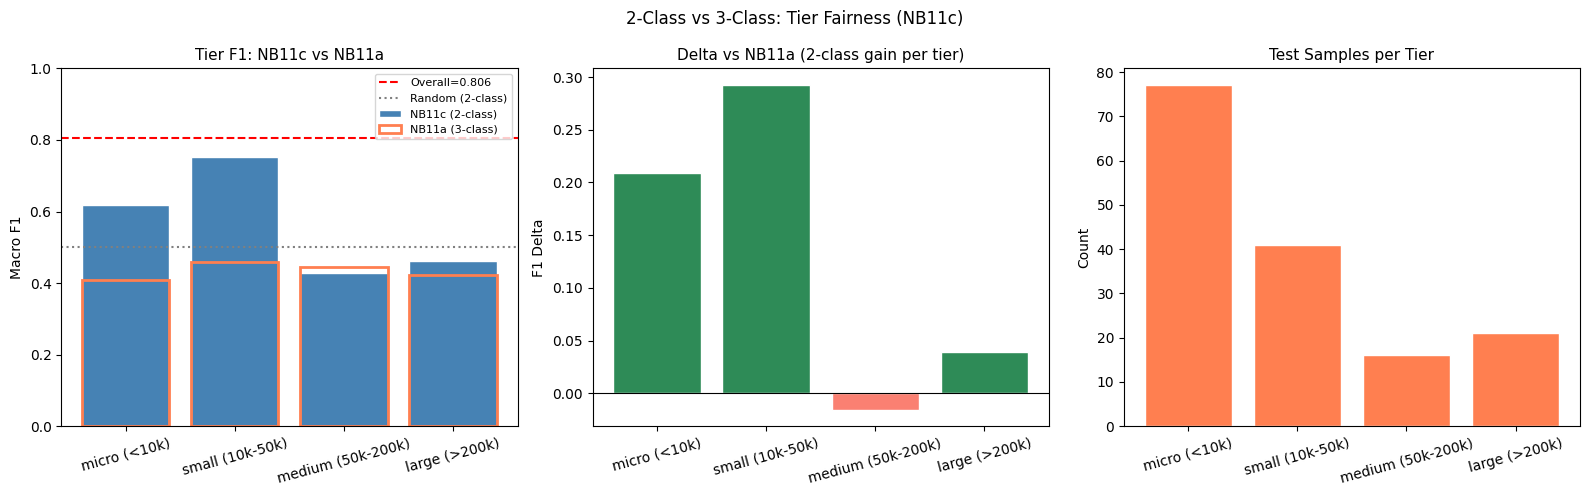

Saved: ../data/11c_tier_evaluation.png


In [20]:
if tier_results:
    tier_df = pd.DataFrame(tier_results)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    axes[0].bar(tier_df['tier'], tier_df['macro_f1'], color='steelblue', edgecolor='white', label='NB11c (2-class)')
    axes[0].bar(tier_df['tier'], tier_df['macro_f1_ref'], color='none', edgecolor='coral', linewidth=2, label='NB11a (3-class)')
    axes[0].axhline(best_row['macro_f1'], color='red', linestyle='--', label=f'Overall={best_row["macro_f1"]:.3f}')
    axes[0].axhline(0.5, color='gray', linestyle=':', label='Random (2-class)')
    axes[0].set_title('Tier F1: NB11c vs NB11a', fontsize=11)
    axes[0].set_ylabel('Macro F1')
    axes[0].set_ylim(0, 1)
    axes[0].legend(fontsize=8)
    axes[0].tick_params(axis='x', labelrotation=15)

    colors = ['seagreen' if d >= 0 else 'salmon' for d in tier_df['delta']]
    axes[1].bar(tier_df['tier'], tier_df['delta'], color=colors, edgecolor='white')
    axes[1].axhline(0, color='black', linewidth=0.8)
    axes[1].set_title('Delta vs NB11a (2-class gain per tier)', fontsize=11)
    axes[1].set_ylabel('F1 Delta')
    axes[1].tick_params(axis='x', labelrotation=15)

    axes[2].bar(tier_df['tier'], tier_df['n'], color='coral', edgecolor='white')
    axes[2].set_title('Test Samples per Tier', fontsize=11)
    axes[2].set_ylabel('Count')
    axes[2].tick_params(axis='x', labelrotation=15)

    plt.suptitle('2-Class vs 3-Class: Tier Fairness (NB11c)', fontsize=12)
    plt.tight_layout()
    plt.savefig('../data/11c_tier_evaluation.png', dpi=100, bbox_inches='tight')
    plt.show()
    print('Saved: ../data/11c_tier_evaluation.png')


## 13. Full Results Summary

In [21]:
print('=' * 65)
print('NB11c -- 2-CLASS ENGAGEMENT RATE CLASSIFICATION')
print('Experiment C: Binary median split')
print('=' * 65)
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

print(f'\nClass threshold (training median): {median_rate:.3f}')

print(f'\nComparison (raw F1):')
print(f'  NB11  (3-class, global, with followers):   0.5997')
print(f'  NB11a (3-class, global, no followers):     0.5301')
print(f'  NB11b (3-class, within-tier):              0.4306')
print(f'  NB11c (2-class, median split):             {best_row["macro_f1"]}')

print(f'\nLift over random baseline (more comparable across class counts):')
print(f'  NB11:  0.5997 - 0.333 = +0.267')
print(f'  NB11a: 0.5301 - 0.333 = +0.197')
print(f'  NB11b: 0.4306 - 0.333 = +0.098')
lift = round(best_row['macro_f1'] - 0.5, 4)
print(f'  NB11c: {best_row["macro_f1"]} - 0.500 = +{lift}')


NB11c -- 2-CLASS ENGAGEMENT RATE CLASSIFICATION
Experiment C: Binary median split
            model  macro_f1    acc
RandomForest_base    0.7871 0.7871
     XGBoost_base    0.8064 0.8065
    LightGBM_base    0.7935 0.7935
    XGBoost_tuned    0.7868 0.7871
   LightGBM_tuned    0.7935 0.7935

Class threshold (training median): 5.985

Comparison (raw F1):
  NB11  (3-class, global, with followers):   0.5997
  NB11a (3-class, global, no followers):     0.5301
  NB11b (3-class, within-tier):              0.4306
  NB11c (2-class, median split):             0.8064

Lift over random baseline (more comparable across class counts):
  NB11:  0.5997 - 0.333 = +0.267
  NB11a: 0.5301 - 0.333 = +0.197
  NB11b: 0.4306 - 0.333 = +0.098
  NB11c: 0.8064 - 0.500 = +0.3064


## 14. Conclusions -- Experiment C (2-Class)

### What This Experiment Tests
Binary classification removes the structurally ambiguous Average class.
The model predicts only: below median or above median engagement rate.

### Interpreting F1 for 2-class vs 3-class
The random baseline shifts from 0.333 (3-class) to 0.500 (2-class).
Compare lift over random baseline, not raw F1:

```
lift = macro_f1 - random_baseline
NB11:  0.5997 - 0.333 = +0.267  (3-class with follower shortcut)
NB11a: 0.5301 - 0.333 = +0.197  (3-class, content-only)
NB11c: [F1]   - 0.500 = [lift]  (2-class, content-focused)
```

### Practical Interpretation
A 2-class model is simpler and more actionable:
- Class 1: Above average -- content likely to over-perform
- Class 0: Below average -- content likely to under-perform

There is no ambiguous middle. Every post gets a clear directional signal.
This makes the model easier to explain and act on.

### Recommended Next Step
Add text embeddings (SBERT or TF-IDF of clean_content) to the 2-class model.
The current feature set is rule-based; embeddings would capture semantic
content quality that keyword flags cannot reach.
